In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch
import os
from utils.common import (
    m2f_dataset_collate,
    m2f_extract_pred_maps_and_masks,
    BG_VALUE,
    set_seed,
    pixel_mean_std,
    CADIS_PIXEL_MEAN,
    CADIS_PIXEL_STD,
    CAT1K_PIXEL_MEAN,
    CAT1K_PIXEL_STD,
)
from utils.dataset_utils import (
    get_cadisv2_dataset,
    get_cataract1k_dataset,
    ZEISS_CATEGORIES,
)
from utils.medical_datasets import Mask2FormerDataset
from transformers import (
    Mask2FormerForUniversalSegmentation,
    SwinModel,
    SwinConfig,
    Mask2FormerConfig,
    AutoImageProcessor,
    Mask2FormerImageProcessor
)
from torch.utils.data import DataLoader
import evaluate
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from dotenv import load_dotenv
import wandb

In [28]:
set_seed(42) # seed everything

In [29]:
NUM_CLASSES = len(ZEISS_CATEGORIES) - 3  # Remove class incremental
SWIN_BACKBONE = "microsoft/swin-tiny-patch4-window7-224"#"microsoft/swin-large-patch4-window12-384"

# Download pretrained swin model
swin_model = SwinModel.from_pretrained(
    SWIN_BACKBONE, out_features=["stage1", "stage2", "stage3", "stage4"]
)
swin_config = SwinConfig.from_pretrained(
    SWIN_BACKBONE, out_features=["stage1", "stage2", "stage3", "stage4"]
)

# Create Mask2Former configuration based on Swin's configuration
mask2former_config = Mask2FormerConfig(
    backbone_config=swin_config, num_labels=NUM_CLASSES #, ignore_value=BG_VALUE
)

# Create the Mask2Former model with this configuration
model = Mask2FormerForUniversalSegmentation(mask2former_config)

# Reuse pretrained parameters
for swin_param, m2f_param in zip(
    swin_model.named_parameters(),
    model.model.pixel_level_module.encoder.named_parameters(),
):
    m2f_param_name = f"model.pixel_level_module.encoder.{m2f_param[0]}"

    if swin_param[0] == m2f_param[0]:
        model.state_dict()[m2f_param_name].copy_(swin_param[1])
        continue

    print(f"Not Matched: {m2f_param[0]} != {swin_param[0]}")

/notebooks/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Not Matched: hidden_states_norms.stage1.weight != layernorm.weight
Not Matched: hidden_states_norms.stage1.bias != layernorm.bias


In [30]:
# Helper function to load datasets
def load_dataset(dataset_getter, data_path, domain_incremental):
    return dataset_getter(data_path, domain_incremental=domain_incremental)


# Helper function to create dataloaders for a dataset
def create_dataloaders(
    dataset, batch_size, shuffle, num_workers, drop_last, pin_memory, collate_fn
):
    return {
        "train": DataLoader(
            dataset["train"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
        "val": DataLoader(
            dataset["val"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
        "test": DataLoader(
            dataset["test"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
    }


# Load datasets
datasets = {
    "A": load_dataset(get_cadisv2_dataset, "../../storage/data/CaDISv2", True),
    "B": load_dataset(get_cataract1k_dataset, "../../storage/data/cataract-1k", True),
}

# pixel_mean_A,pixel_std_A=pixel_mean_std(datasets["A"][0])
pixel_mean_A = CADIS_PIXEL_MEAN
pixel_std_A = CADIS_PIXEL_STD

# pixel_mean_B,pixel_std_B=pixel_mean_std(datasets["B"][0])
pixel_mean_B = CAT1K_PIXEL_MEAN
pixel_std_B = CAT1K_PIXEL_STD

# Define preprocessor
swin_processor = AutoImageProcessor.from_pretrained(SWIN_BACKBONE)
m2f_preprocessor_A = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_A,
    image_mean=pixel_mean_A,
)

m2f_preprocessor_B = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_B,
    image_mean=pixel_mean_B,
)

# Create Mask2Former Datasets
m2f_datasets = {
    "A": {
        "train": Mask2FormerDataset(datasets["A"][0], m2f_preprocessor_A),
        "val": Mask2FormerDataset(datasets["A"][1], m2f_preprocessor_A),
        "test": Mask2FormerDataset(datasets["A"][2], m2f_preprocessor_A),
    },
    "B": {
        "train": Mask2FormerDataset(datasets["B"][0], m2f_preprocessor_B),
        "val": Mask2FormerDataset(datasets["B"][1], m2f_preprocessor_B),
        "test": Mask2FormerDataset(datasets["B"][2], m2f_preprocessor_B),
    },
}

# DataLoader parameters
N_WORKERS = 4
BATCH_SIZE = 1
SHUFFLE = True
DROP_LAST = True

dataloader_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": SHUFFLE,
    "num_workers": N_WORKERS,
    "drop_last": DROP_LAST,
    "pin_memory": True,
    "collate_fn": m2f_dataset_collate,
}

# Create DataLoaders
dataloaders = {
    key: create_dataloaders(m2f_datasets[key], **dataloader_params)
    for key in m2f_datasets
}

print(dataloaders)

/notebooks/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


{'A': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc43ae8ba50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc43a668e90>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fc43b1eab10>}, 'B': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc43ebf2450>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc43ebf2010>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fc43ebf3b90>}}


In [31]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [32]:
# Tensorboard setup
out_dir="outputs/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(out_dir+"runs"):
    os.makedirs(out_dir+"runs")
%load_ext tensorboard
%tensorboard --logdir outputs/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3136), started 0:55:54 ago. (Use '!kill 3136' to kill it.)

In [33]:
# Training
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
LR_MULTIPLIER = 0.1
BACKBONE_LR = LEARNING_RATE * LR_MULTIPLIER
WEIGHT_DECAY = 0.5
metric = evaluate.load("mean_iou")
encoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.encoder")
]
decoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.decoder")
]
transformer_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.transformer_module")
]
optimizer = optim.AdamW(
    [
        {"params": encoder_params, "lr": BACKBONE_LR},
        {"params": decoder_params},
        {"params": transformer_params},
    ],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

scheduler = optim.lr_scheduler.PolynomialLR(
    optimizer, total_iters=NUM_EPOCHS, power=0.9
)

In [34]:
# WandB for team usage !!!!

wandb.login() # use this one if a different person is going to run the notebook
#wandb.login(relogin=False) # if the same person in the last run is going to run the notebook again


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [35]:
wandb.init(
    project="M2F_original",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_multiplier": LR_MULTIPLIER,
        "backbone_learning_rate": BACKBONE_LR,
        "learning_rate_scheduler": scheduler.__class__.__name__,
        "optimizer": optimizer.__class__.__name__,
        "backbone": SWIN_BACKBONE,
        "m2f_preprocessor": m2f_preprocessor_A.__dict__,
        "m2f_model_config": model.config
    },
    name="M2F-Swin-Tiny-Train_OVERFIT_2",
    notes="M2F-Swin-Tiny-Train_OVERFIT_2"
)

Loss/train_A,█▆▂▁▃
Loss/val_A,█▃▁▁▁
mIoU/train_A,▁▃▅▄█
mIoU/val_A,▄▆██▁
Loss/train_A,0.02615
Loss/val_A,89.87546
mIoU/train_A,0.38342
mIoU/val_A,0.04298


In [36]:
# Tensorboard logging
writer = SummaryWriter(log_dir=out_dir + "runs")

# Model checkpointing
base_model_name="m2f_swin_backbone_train_cadis_overfit_2"
model_dir = out_dir + "models/"
if not os.path.exists(model_dir):
    print("Store weights in: ", model_dir)
    os.makedirs(model_dir)

best_model_dir = model_dir + f"{base_model_name}/best_model/"
if not os.path.exists(best_model_dir):
    print("Store best model weights in: ", best_model_dir)
    os.makedirs(best_model_dir)
final_model_dir = model_dir + f"{base_model_name}/final_model/"
if not os.path.exists(final_model_dir):
    print("Store final model weights in: ", final_model_dir)
    os.makedirs(final_model_dir)

In [37]:
m2f_preprocessor_A.save_pretrained(model_dir + base_model_name)

['outputs/models/m2f_swin_backbone_train_cadis_overfit_2/preprocessor_config.json']

In [38]:
# To avoid making stupid errors
CURR_TASK = "A"

# For storing the model
best_val_metric = -np.inf

# Move model to device
model.to(device)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_running_loss = 0.0
    val_running_loss = 0.0

    # Get a single data point from the training data
    batch = next(iter(dataloaders[CURR_TASK]["train"]))

    # Move everything to the device
    batch["pixel_values"] = batch["pixel_values"].to(device)
    batch["pixel_mask"] = batch["pixel_mask"].to(device)
    batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
    batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]

    # Compute output and loss
    outputs = model(**batch)

    loss = outputs.loss

    # Compute gradient and perform step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record losses
    current_loss = loss.item() * batch["pixel_values"].size(0)
    train_running_loss += current_loss

    # Extract and compute metrics
    pred_maps, masks = m2f_extract_pred_maps_and_masks(
        batch, outputs, m2f_preprocessor_A
    )
    metric.add_batch(references=masks, predictions=pred_maps)

    # After compute the batches that were added are deleted
    mean_train_iou = metric.compute(
        num_labels=NUM_CLASSES, ignore_index=BG_VALUE, reduce_labels=False
    )["mean_iou"]

    # Validation phase
    model.eval()
    val_loader = tqdm(
        dataloaders[CURR_TASK]["val"], desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} Validation"
    )
    with torch.no_grad():
        for batch1 in val_loader:
            # Move everything to the device
            batch1["pixel_values"] = batch1["pixel_values"].to(device)
            batch1["pixel_mask"] = batch1["pixel_mask"].to(device)
            batch1["mask_labels"] = [entry.to(device) for entry in batch1["mask_labels"]]
            batch1["class_labels"] = [
                entry.to(device) for entry in batch1["class_labels"]
            ]
            # Compute output and loss
            outputs = model(**batch1)

            loss = outputs.loss
            # Record losses
            current_loss = loss.item() * batch1["pixel_values"].size(0)
            val_running_loss += current_loss

            # Extract and compute metrics
            pred_maps, masks = m2f_extract_pred_maps_and_masks(
                batch1, outputs, m2f_preprocessor_A
            )
            metric.add_batch(references=masks, predictions=pred_maps)

    # After compute the batches that were added are deleted
    mean_val_iou = metric.compute(
        num_labels=NUM_CLASSES, ignore_index=BG_VALUE, reduce_labels=False
    )["mean_iou"]

    epoch_train_loss = train_running_loss / len(dataloaders[CURR_TASK]["train"].dataset)
    epoch_val_loss = val_running_loss / len(dataloaders[CURR_TASK]["val"].dataset)

    writer.add_scalar(f"Loss/train_{base_model_name}_{CURR_TASK}", epoch_train_loss, epoch + 1)
    writer.add_scalar(f"Loss/val_{base_model_name}_{CURR_TASK}", epoch_val_loss, epoch + 1)
    writer.add_scalar(f"mIoU/train_{base_model_name}_{CURR_TASK}", mean_train_iou, epoch + 1)
    writer.add_scalar(f"mIoU/val_{base_model_name}_{CURR_TASK}", mean_val_iou, epoch + 1)

    wandb.log({
        f"Loss/train_{CURR_TASK}": epoch_train_loss,
        f"Loss/val_{CURR_TASK}": epoch_val_loss,
        f"mIoU/train_{CURR_TASK}": mean_train_iou,
        f"mIoU/val_{CURR_TASK}": mean_val_iou
    })

    if mean_val_iou > best_val_metric:
        best_val_metric = mean_val_iou
        model.save_pretrained(f"{best_model_dir}{CURR_TASK}/")

    tqdm.write(
        f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Train mIoU: {mean_train_iou:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation mIoU: {mean_val_iou:.4f}"
    )


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Epoch 1/5 Validation: 100%|██████████| 534/534 [02:07<00:00,  4.17it/s]


Epoch 1/5, Train Loss: 0.0359, Train mIoU: 0.0000, Validation Loss: 107.8157, Validation mIoU: 0.0001


Epoch 2/5 Validation: 100%|██████████| 534/534 [01:58<00:00,  4.52it/s]


Epoch 2/5, Train Loss: 0.0303, Train mIoU: 0.0000, Validation Loss: 99.6995, Validation mIoU: 0.0545


Epoch 3/5 Validation: 100%|██████████| 534/534 [02:11<00:00,  4.05it/s]


Epoch 3/5, Train Loss: 0.0294, Train mIoU: 0.1439, Validation Loss: 95.5916, Validation mIoU: 0.0548


Epoch 4/5 Validation: 100%|██████████| 534/534 [02:19<00:00,  3.84it/s]


Epoch 4/5, Train Loss: 0.0269, Train mIoU: 0.2424, Validation Loss: 92.4814, Validation mIoU: 0.0548


Epoch 5/5 Validation: 100%|██████████| 534/534 [02:09<00:00,  4.11it/s]


Epoch 5/5, Train Loss: 0.0255, Train mIoU: 0.1671, Validation Loss: 90.4679, Validation mIoU: 0.0548


In [39]:
print(batch)

{'pixel_values': tensor([[[[-0.6599, -0.6210, -0.5773,  ..., -1.4423, -1.3119, -1.2121],
          [-0.6871, -0.6618, -0.6224,  ..., -1.4123, -1.4164, -1.3834],
          [-0.7950, -0.7973, -0.7446,  ..., -1.2681, -1.3394, -1.3496],
          ...,
          [-0.7619, -0.6404, -0.5171,  ...,  0.8542,  0.4234,  0.5842],
          [-0.6904, -0.4088, -0.3213,  ...,  1.2972,  1.0112,  0.8615],
          [-0.3316, -0.0108,  0.1335,  ...,  1.5849,  1.4724,  1.1228]],

         [[-0.5271, -0.5054, -0.4705,  ..., -1.5919, -1.5132, -1.4166],
          [-0.5452, -0.5342, -0.5099,  ..., -1.5663, -1.5769, -1.5400],
          [-0.6163, -0.6140, -0.5886,  ..., -1.4774, -1.5158, -1.5109],
          ...,
          [-0.8954, -0.8085, -0.6982,  ...,  0.6040,  0.3003,  0.3955],
          [-0.7993, -0.6344, -0.5416,  ...,  0.9269,  0.6991,  0.5991],
          [-0.5547, -0.3220, -0.2227,  ...,  1.1117,  1.0092,  0.7648]],

         [[-0.3111, -0.3090, -0.2591,  ..., -1.2174, -1.1442, -1.0736],
          [-0

In [42]:
!pip install matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'): 0 pixels


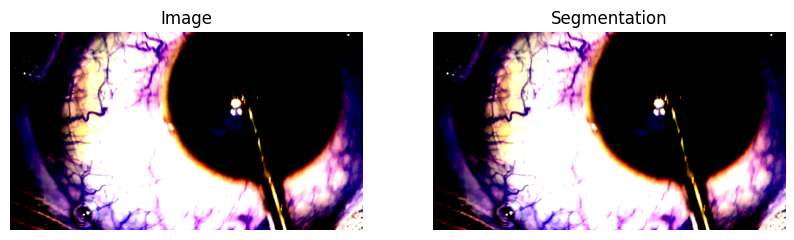

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_segmentation(batch, mask_labels):
    image = batch["pixel_values"][0]  # Assuming only one image in the batch
    pixel_mask = batch["pixel_mask"][0]  # Assuming only one image in the batch

    plt.figure(figsize=(10, 5))

    # Convert CUDA tensor to NumPy array
    if torch.is_tensor(image):
        image = image.cpu().numpy()
    if torch.is_tensor(pixel_mask):
        pixel_mask = pixel_mask.cpu().numpy()

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.transpose(1, 2, 0))  # Transpose image dimensions if necessary
    plt.title('Image')
    plt.axis('off')

    # Display the segmentation masks
    plt.subplot(1, 2, 2)
    plt.imshow(image.transpose(1, 2, 0))  # Transpose image dimensions if necessary
    cmap = ListedColormap(np.random.rand(len(mask_labels), 3))
    for j, label in enumerate(mask_labels):
        mask = pixel_mask == j
        plt.contour(mask, levels=[0.5], colors=[cmap(j)], alpha=0.8)  # Adjust contour levels if necessary
        print(f"Label {label}: {np.sum(mask)} pixels")
    plt.title('Segmentation')
    plt.axis('off')

    plt.show()

# Assuming batch1 contains the necessary data


visualize_segmentation(batch, batch["mask_labels"])


In [53]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels'])

In [72]:
batch["pixel_mask"][0].shape

torch.Size([270, 480])

In [61]:
np.unique(pixel_mask_numpy)

array([1])

In [73]:
model

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value